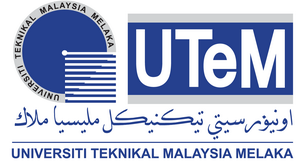

# Recurrent Neural Network 

Dataset resource: https://www.kaggle.com/datasets/francoisraucent/western-europe-power-consumption/code?resource=download

Western Europe Consumption data has been retrieved for each of the following countries : Austria, Belgium, Switzerland, Denmark, Germany, Spain, France, UK, Italy, Ireland, Luxembourg, the Netherlands, Norway, Portugal, and Sweden. The time resolution is either 15 minutes, 30 minutes or 1 hour depending on the country.

The consumption is given in Megawatts (MW) and goes from January 2015 up to August 2020.

There are multiple dataset exist in the link. For this class, the choice will be power consumption of Germany, given in Megawatts (MW).

### Import the relevent packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Read .csv file and view a part of the data

In [3]:
data = pd.read_csv('de.csv')
print(data.head(5))

                       start                        end     load
0  2015-01-01 00:00:00+00:00  2015-01-01 00:15:00+00:00  41917.0
1  2015-01-01 00:15:00+00:00  2015-01-01 00:30:00+00:00  41518.0
2  2015-01-01 00:30:00+00:00  2015-01-01 00:45:00+00:00  41179.0
3  2015-01-01 00:45:00+00:00  2015-01-01 01:00:00+00:00  40756.0
4  2015-01-01 01:00:00+00:00  2015-01-01 01:15:00+00:00  40618.0


### Remove unwanted column

From the previous command, we found that there is three column, for analysis, we will remove the end date and take the start date as date reference

In [4]:
data_de = data.drop(['end'], axis=1)
print("data_de = ", data_de.shape)
print(data_de.head(5))

data_de =  (198721, 2)
                       start     load
0  2015-01-01 00:00:00+00:00  41917.0
1  2015-01-01 00:15:00+00:00  41518.0
2  2015-01-01 00:30:00+00:00  41179.0
3  2015-01-01 00:45:00+00:00  40756.0
4  2015-01-01 01:00:00+00:00  40618.0


### Viewing the finalized dataset

In [5]:
data_de = data[['start', 'load']]
data_de['start'] = pd.to_datetime(data_de['start'])
data_de = data_de.set_index("start")
data_de=data_de.groupby(pd.Grouper(freq="h")).sum()
data_de['start'] = pd.to_datetime(data_de.index)

C:\Users\01907\AppData\Local\Temp\ipykernel_17004\639254364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_de['start'] = pd.to_datetime(data_de['start'])


### Select new dataset

In [6]:
#data from 2020-01-01 to 2020-08-30
selectData = data_de.loc[(data_de['start'] > '2019-05-01 00:00') & (data_de['start'] < '2020-09-01 00:00')]
selectData = selectData.set_index('start')
selectData.index = pd.to_datetime(selectData.index)
selectData = selectData.groupby(pd.Grouper(freq="h")).sum() #set in hourly
print("select data = ",selectData['load'].shape)
print(selectData.head())

select data =  (11735,)
                               load
start                              
2019-05-01 01:00:00+00:00  162833.0
2019-05-01 02:00:00+00:00  162921.0
2019-05-01 03:00:00+00:00  160130.0
2019-05-01 04:00:00+00:00  154445.0
2019-05-01 05:00:00+00:00  161567.0


### Setting the training dataset

Take a part of the dataset as training data based on time.
After that set time which is 'start' column as index
By using pandas.to_datetime() function to convert the scalar to date time pandas object
By using the .groupby( ) hour time, sum the load so that refer in term of days. 

In [7]:
#data from 2019-05-01 to 2020-02-28 as traing dataset
train_set = data_de[(data_de['start'] > '2019-05-01 00:00') & (data_de['start'] <'2020-02-28 00:00')]
train_set = train_set.set_index('start')
train_set.index = pd.to_datetime(train_set.index)
train_set = train_set.groupby(pd.Grouper(freq="h")).sum()  #set in hourly
print("train_set = ",train_set['load'].shape)
print(train_set.head())

train_set =  (7271,)
                               load
start                              
2019-05-01 01:00:00+00:00  162833.0
2019-05-01 02:00:00+00:00  162921.0
2019-05-01 03:00:00+00:00  160130.0
2019-05-01 04:00:00+00:00  154445.0
2019-05-01 05:00:00+00:00  161567.0


### Setting the validation dataset

In [8]:
#data from 2020-05-31 to 2020-07-1 as test set
val_set = data_de.loc[(data_de['start'] > '2020-02-28 00:00') & (data_de['start'] < '2020-07-31 00:00')]
val_set = val_set.set_index('start')
val_set.index = pd.to_datetime(val_set.index)
val_set = val_set.groupby(pd.Grouper(freq="h")).sum() #set in hourly
print("val_set = ",val_set['load'].shape)
print(val_set.head())

val_set =  (3695,)
                               load
start                              
2020-02-28 01:00:00+00:00  210113.0
2020-02-28 02:00:00+00:00  208996.0
2020-02-28 03:00:00+00:00  212315.0
2020-02-28 04:00:00+00:00  224743.0
2020-02-28 05:00:00+00:00  248335.0


### Setting the test dataset

In [9]:
#data from 2020-07-1 to 2020-09-1 as test set
test_set = data_de.loc[(data_de['start'] > '2020-07-31 00:00') & (data_de['start'] < '2020-09-01 00:00')]
test_set = test_set.set_index('start')
test_set.index = pd.to_datetime(test_set.index)
test_set = test_set.groupby(pd.Grouper(freq="h")).sum() #set in hourly
print("test_set = ",test_set['load'].shape)
print(test_set.head())

test_set =  (767,)
                               load
start                              
2020-07-31 01:00:00+00:00  156083.0
2020-07-31 02:00:00+00:00  159535.0
2020-07-31 03:00:00+00:00  167995.0
2020-07-31 04:00:00+00:00  187305.0
2020-07-31 05:00:00+00:00  210678.0


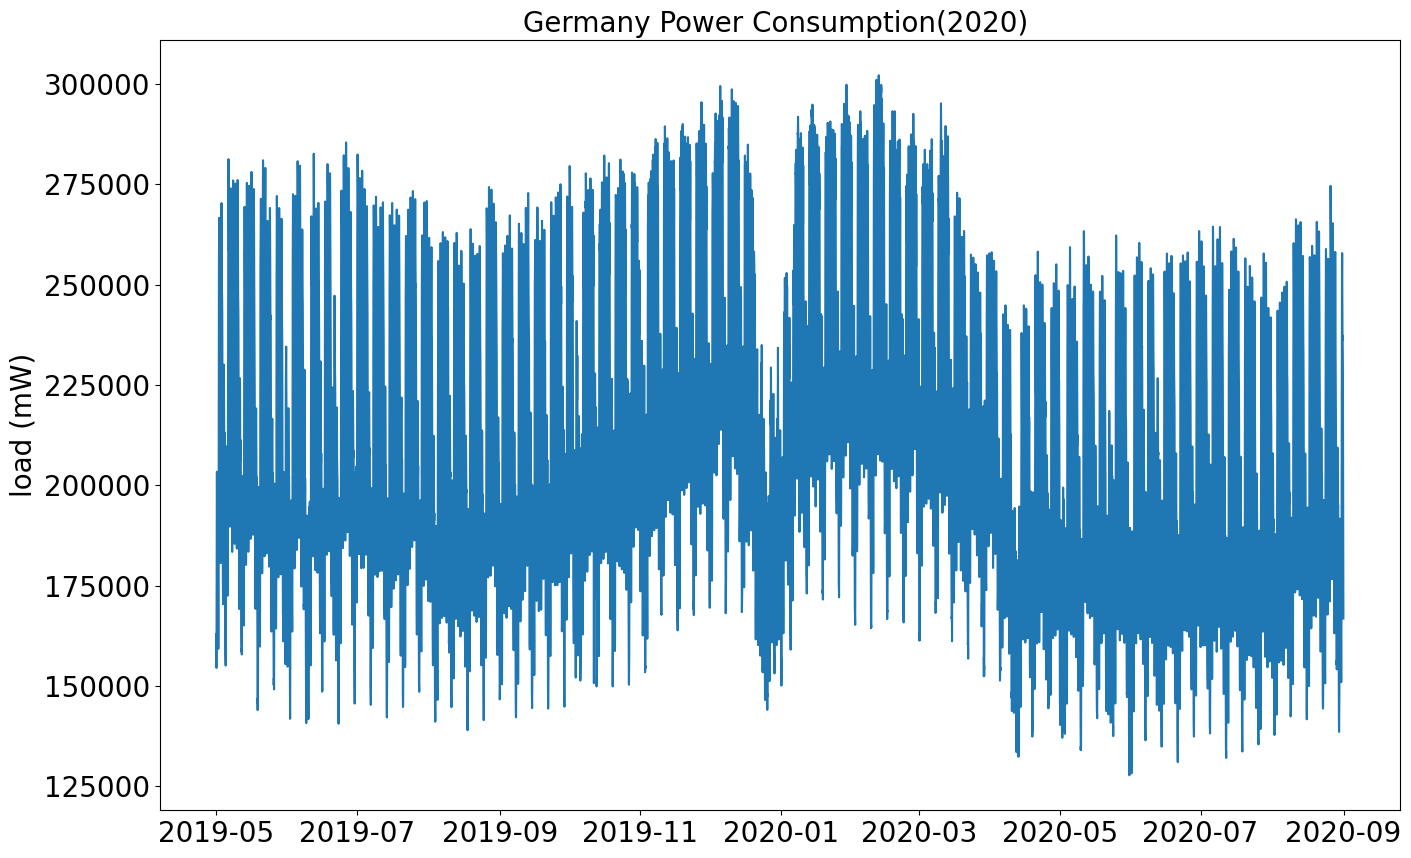

In [10]:
selectData['start'] = pd.to_datetime(selectData.index)
plt.figure(figsize=(16,10))
plt.plot(selectData['start'], selectData['load'])
plt.ylabel("load (mW)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Germany Power Consumption(2020) ',fontsize=20)
plt.show()

### Preprocessing Standardization

In [11]:
scaler = StandardScaler()
scaler = scaler.fit(train_set[['load']])

train_set['load'] = scaler.transform(train_set[['load']])
val_set['load'] = scaler.transform(val_set[['load']])
test_set['load'] = scaler.transform(test_set[['load']])

### Change the dataset to sequence 

In [12]:
seq_n = 24

def to_sequence(x,y,seq_size):
    x_values = []
    y_values = []
    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        #print(x_values)
        y_values.append(y.iloc[i+seq_size])
        #print(y_values)
    return np.array(x_values), np.array(y_values)

x_train, y_train = to_sequence(train_set[['load']], train_set['load'], seq_n)
x_val, y_val = to_sequence(val_set[['load']], val_set['load'], seq_n)
x_test, y_test = to_sequence(test_set[['load']], test_set['load'], seq_n)


### RNN modelling

In [13]:
model1 = Sequential()
model1.add(SimpleRNN(units=150, return_sequences=True, input_shape=(seq_n, 1)))
model1.add(SimpleRNN(units=50))
model1.add(Dense(units=1))
model1.summary()
model1.compile(optimizer="SGD", loss="mse")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 150)           22800     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                10050     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 32,901
Trainable params: 32,901
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model1.fit(x_train, y_train, epochs=25, validation_data=(x_val, y_val))

Epoch 1/25
227/227 [==============================] - 25s 94ms/step - loss: 0.0571 - val_loss: 0.0248
Epoch 2/25
227/227 [==============================] - 21s 93ms/step - loss: 0.0182 - val_loss: 0.0173
Epoch 3/25
227/227 [==============================] - 18s 79ms/step - loss: 0.0138 - val_loss: 0.0142
Epoch 4/25
227/227 [==============================] - 20s 90ms/step - loss: 0.0117 - val_loss: 0.0160
Epoch 5/25
227/227 [==============================] - 21s 93ms/step - loss: 0.0106 - val_loss: 0.0115
Epoch 6/25
227/227 [==============================] - 21s 93ms/step - loss: 0.0097 - val_loss: 0.0117
Epoch 7/25
227/227 [==============================] - 20s 88ms/step - loss: 0.0093 - val_loss: 0.0103
Epoch 8/25
227/227 [==============================] - 21s 93ms/step - loss: 0.0090 - val_loss: 0.0108
Epoch 9/25
227/227 [==============================] - 21s 93ms/step - loss: 0.0086 - val_loss: 0.0101
Epoch 10/25
227/227 [==============================] - 20s 86ms/step - loss: 0.008

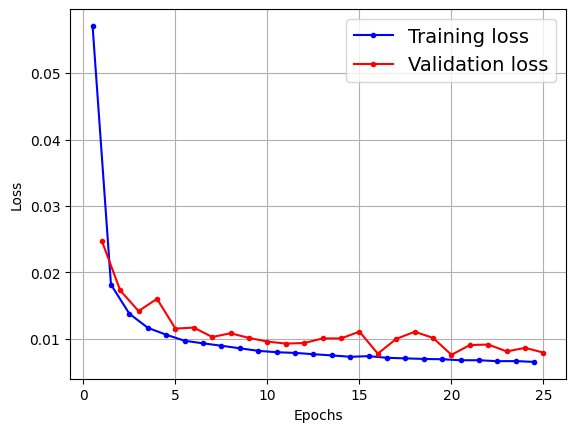

In [15]:
def Learning_curves_graph(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

Learning_curves_graph(history.history["loss"], history.history["val_loss"])
plt.show()

### Computer prediction value

In [16]:
# Compute predictions and error on validation data

y_pred_train = model1.predict(x_train)
y_pred_val = model1.predict(x_val)
y_pred_test = model1.predict(x_test)
print(f"Stacked RNN MSE: {np.mean(mean_squared_error(y_test, y_pred_test)):0.05f}")

24/24 [==============================] - 0s 8ms/step
Stacked RNN MSE: 1.60411


### Inverse Transform Standard Scaler Prediction value

In [17]:
predict_train = scaler.inverse_transform(y_pred_train)
predict_val = scaler.inverse_transform(y_pred_val)
predict_test  = scaler.inverse_transform(y_pred_test)

print(predict_test[0:5])

[[154975.81]
 [151815.11]
 [153081.31]
 [162176.92]
 [171346.66]]


### Inverse Transform Standard Scaler Initial value

In [18]:
train_set['load'] = scaler.inverse_transform(train_set[['load']])
val_set['load'] = scaler.inverse_transform(val_set[['load']])
test_set['load'] = scaler.inverse_transform(test_set[['load']])

print(test_set.head())

                               load
start                              
2020-07-31 01:00:00+00:00  156083.0
2020-07-31 02:00:00+00:00  159535.0
2020-07-31 03:00:00+00:00  167995.0
2020-07-31 04:00:00+00:00  187305.0
2020-07-31 05:00:00+00:00  210678.0


### Visualization of prediction(test_set)

In [19]:
previous_days = seq_n

plottrainpred = np.empty_like(train_set['load'])
#plottrainpred[:] = np.nan
plottrainpred = plottrainpred.reshape(-1,1)
plottrainpred[previous_days:len(train_set)]=predict_train

plotvalpred = np.empty_like(val_set['load'])
#plotvalpred[:] = np.nan
plotvalpred = plotvalpred.reshape(-1,1)
plotvalpred[previous_days:len(val_set)]=predict_val

plottestpred = np.empty_like(test_set['load'])
plottestpred[:] = np.nan
plottestpred = plottestpred.reshape(-1,1)
plottestpred[previous_days:len(test_set)]=predict_test

print(plottrainpred.shape)
print(plotvalpred.shape)
print(plottestpred.shape)

(7271, 1)
(3695, 1)
(767, 1)


In [20]:
df_tpp = pd.DataFrame(data = plottestpred,columns=['load'])
df_tpp['start'] = test_set.index
df_tpp['start'] = pd.to_datetime(df_tpp['start'])
df_tpp = df_tpp.set_index('start')

df_real = test_set['load']

print(df_tpp.iloc[24:30])


                                    load
start                                   
2020-08-01 01:00:00+00:00  154975.812500
2020-08-01 02:00:00+00:00  151815.109375
2020-08-01 03:00:00+00:00  153081.312500
2020-08-01 04:00:00+00:00  162176.921875
2020-08-01 05:00:00+00:00  171346.656250
2020-08-01 06:00:00+00:00  181113.140625


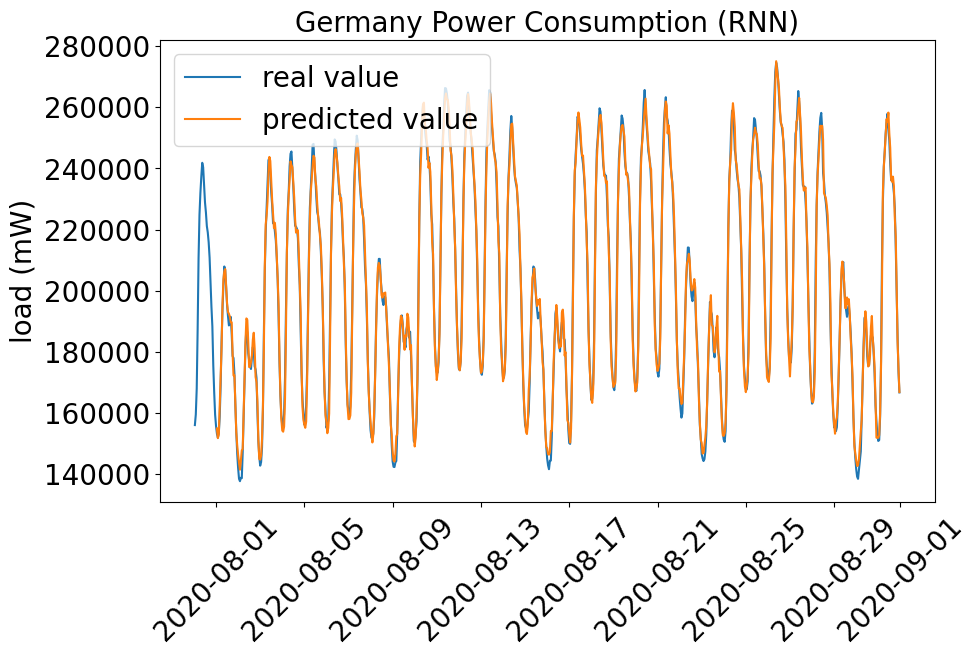

In [21]:
plt.figure(figsize=(10,6))
plt.plot(df_real,label='real value')
plt.xticks(rotation=45)
plt.ylabel("load (mW)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Germany Power Consumption (RNN)',fontsize=20)
plt.plot(df_tpp,label='predicted value')
plt.xticks(rotation=45)
plt.legend(fontsize=20)
plt.show()